# Get bottom conditions for Max's work on sediment BGC
(copernicusmarine_env)

## imports

In [1]:
import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr
import scipy as sci
import h5py as h5

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# regridding package
import xesmf as xe

# statistics package
import skill_metrics as sm

# copernicusmarine
import copernicusmarine

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("xarray version =", xr.__version__)
print("scipy version =", sci.__version__)
print("h5py version =", h5.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("xesmf version =", xe.__version__)


# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

wrkdir = "/home/581/pjb581/for_MaxRintoul/"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 1.26.4
pandas version = 2.2.3
xarray version = 2024.1.1
scipy version = 1.15.1
h5py version = 3.12.1
matplotlib version = 3.10.0
cmocean version = v3.0.3
cartopy version = 0.22.0
xesmf version = 0.8.8


'/home/581/pjb581/for_MaxRintoul'

## Load the reanalysis datasets

In [2]:
DSphy = copernicusmarine.open_dataset(dataset_id="cmems_mod_glo_phy_my_0.083deg-climatology_P1M-m")
DSphy = DSphy.chunk({"time":1, "depth":-1, "latitude":-1, "longitude":216})
# Print memory usage in bytes (NumPy array)
print("Memory of each 4D dataarray (Gbytes):", DSphy.so.nbytes*1e-9)

DSphy

INFO - 2025-02-23T23:47:39Z - Selected dataset version: "202311"
INFO - 2025-02-23T23:47:39Z - Selected dataset part: "default"


Memory of each 4D dataarray (Gbytes): 21.161088000000003


<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 2041, longitude: 4320, time: 12)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 1993-12-01
Data variables:
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 216), meta=np.ndarray>
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 216), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 216), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 216), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 216), meta=np.ndarray>
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 216), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 216), meta=np.ndarray>
    usi        (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 216), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 216), meta=np.ndarray>
    vsi        (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 216), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 216), meta=np.ndarray>
Attributes:
    institution:  Mercator Ocean
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    references:   http://marine.copernicus.eu
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    contact:      servicedesk.cmems@mercator-ocean.eu
    Conventions:  CF-1.6
    title:        Monthly climatology fields for product GLOBAL_REANALYSIS_PH...
    source:       MERCATOR GLORYS12V1

## Bottom Temperature

CPU times: user 1min 26s, sys: 2.86 s, total: 1min 29s
Wall time: 2min 53s


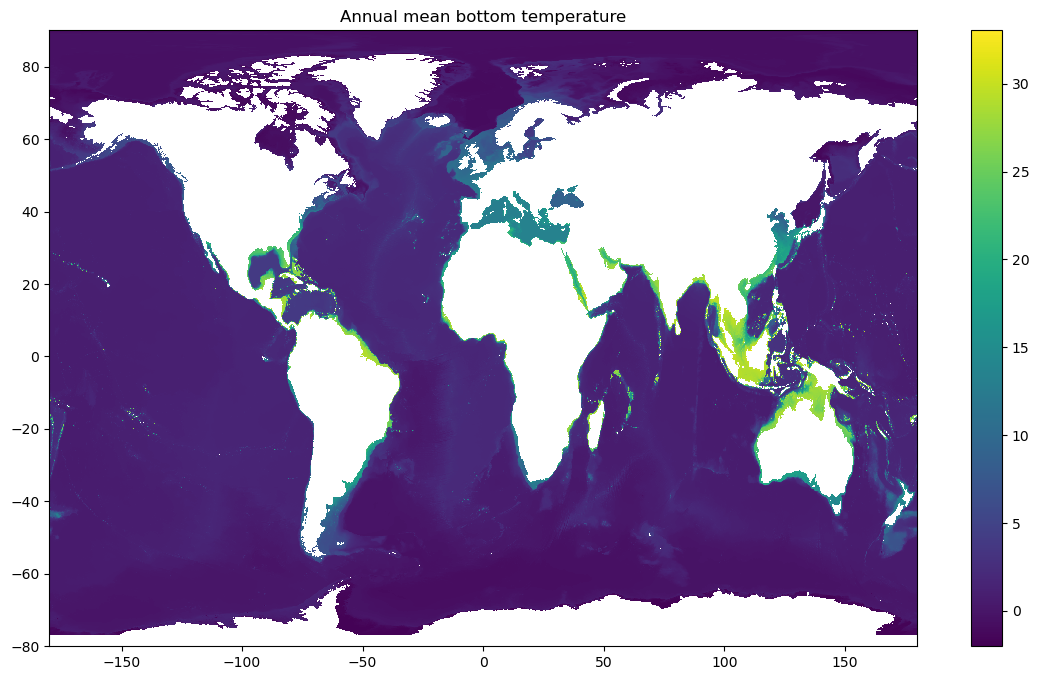

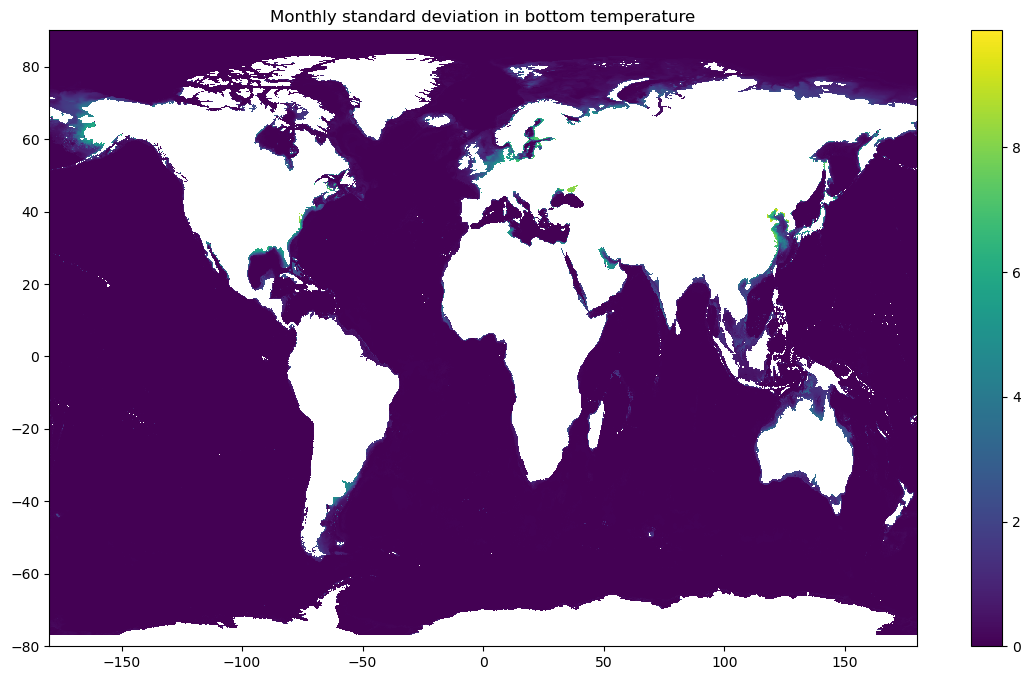

In [26]:
%%time

plt.figure(figsize=(14,8))
plt.title("Annual mean bottom temperature")
plt.pcolormesh(DSphy.coords['longitude'], DSphy.coords['latitude'], DSphy['bottomT'].mean(dim='time'))
plt.colorbar()

plt.figure(figsize=(14,8))
plt.title("Monthly standard deviation in bottom temperature")
plt.pcolormesh(DSphy.coords['longitude'], DSphy.coords['latitude'], DSphy['bottomT'].std(dim='time'))
plt.colorbar()


## Find the bottom-most salinity values

In [27]:
%%time

so = DSphy['so']

# 1. Reverse along depth so bottom cells appear first
so_reversed = so.isel(depth=slice(None, None, -1))

# 2. For each (time, lat, lon), find the index of the first non-NaN in the reversed array
idx_reversed = so_reversed.notnull().argmax(dim="depth")

# 3. Convert reversed index back to the forward depth index
idx_forward = so.depth.size - 1 - idx_reversed


CPU times: user 43.4 ms, sys: 5.92 ms, total: 49.3 ms
Wall time: 187 ms


In [32]:
%%time

idx_forward = idx_forward.compute()
idx_forward


CPU times: user 4min 54s, sys: 39 s, total: 5min 33s
Wall time: 36min 51s


<xarray.DataArray 'so' (time: 12, latitude: 2041, longitude: 4320)>
array([[[49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [49, 49, 49, ..., 49, 49, 49]],

       [[49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [49, 49, 49, ..., 49, 49, 49]],

       [[49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        ...,
...
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [49, 49, 49, ..., 49, 49, 49]],

       [[49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [49, 49, 49, ..., 49, 49, 49]],

       [[49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [49, 49, 49, ..., 49, 49, 49]]])
Coordinates:
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 1993-12-01

## Save this file for later

In [33]:
%%time

idx_forward.to_netcdf("/g/data/es60/observations/copernicus_reanalyses/deepest_grid_cell_index.nc")


CPU times: user 38.2 ms, sys: 1.42 s, total: 1.46 s
Wall time: 7.58 s


In [35]:
%%time

# pick the bottom salinity values
so_bottom = so.isel(depth=idx_forward)
so_bottom


CPU times: user 30min 18s, sys: 35.6 s, total: 30min 54s
Wall time: 30min 49s


<xarray.DataArray 'so' (time: 12, latitude: 2041, longitude: 4320)>
dask.array<reshape, shape=(12, 2041, 4320), dtype=float32, chunksize=(2, 2041, 4320), chunktype=numpy.ndarray>
Coordinates:
    depth      (time, latitude, longitude) float32 5.728e+03 ... 5.728e+03
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 1993-12-01
Attributes:
    cell_methods:   area: mean
    long_name:      Salinity
    standard_name:  sea_water_salinity
    unit_long:      Practical Salinity Unit
    units:          1e-3

## Also save for later

In [37]:
%%time

so_bottom.to_netcdf("/g/data/es60/observations/copernicus_reanalyses/bottomS.nc")


In [38]:
%%time

DSphy['bottomT'].to_netcdf("/g/data/es60/observations/copernicus_reanalyses/bottomT.nc")


CPU times: user 33.4 s, sys: 7.13 s, total: 40.5 s
Wall time: 1min 32s


CPU times: user 27min 13s, sys: 1min 36s, total: 28min 50s
Wall time: 1h 28min 59s


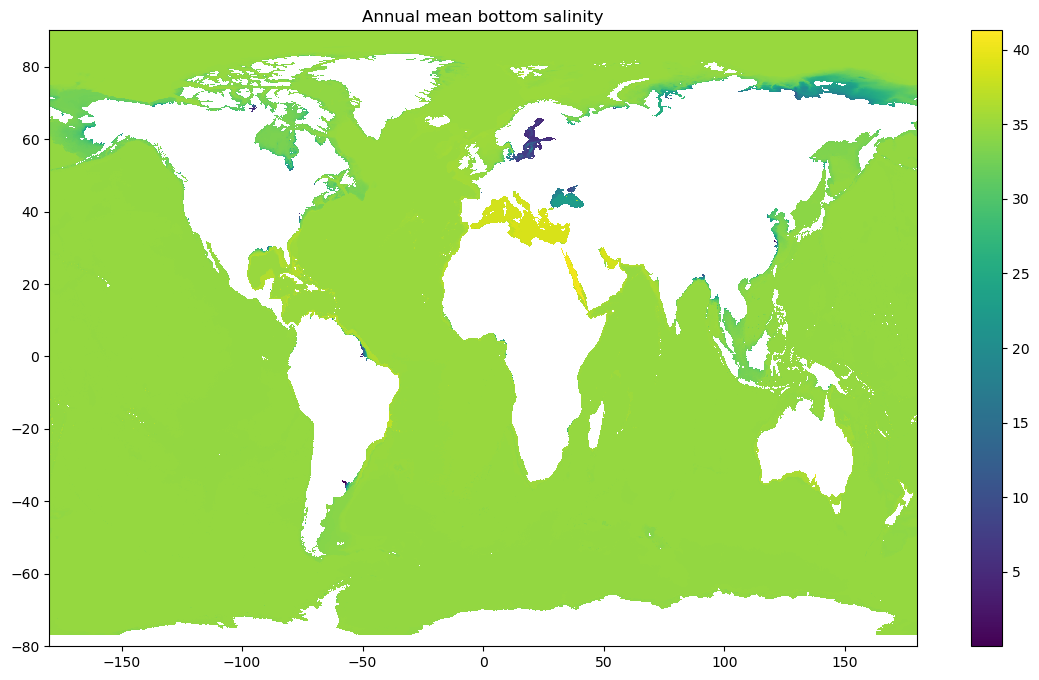

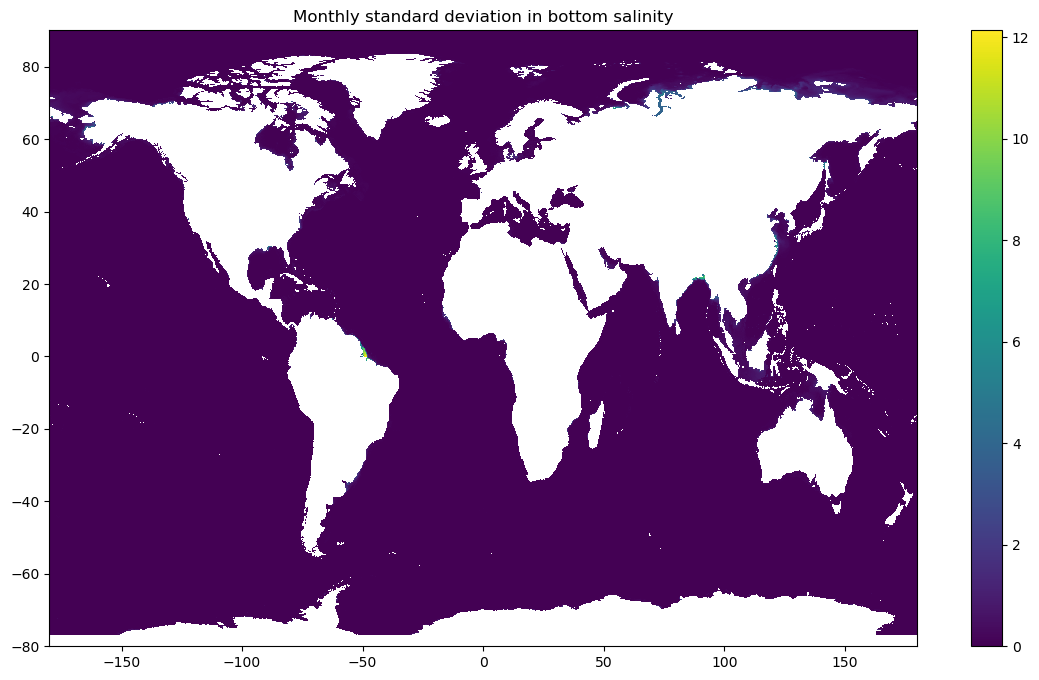

In [40]:
%%time

plt.figure(figsize=(14,8))
plt.title("Annual mean bottom salinity")
plt.pcolormesh(so_bottom.coords['longitude'], so_bottom.coords['latitude'], so_bottom.mean(dim='time'))
plt.colorbar()

plt.figure(figsize=(14,8))
plt.title("Monthly standard deviation in bottom salinity")
plt.pcolormesh(so_bottom.coords['longitude'], so_bottom.coords['latitude'], so_bottom.std(dim='time'))
plt.colorbar()


## Load the biogeochemistry variables from the Copernicus reanalysis

In [3]:
DSbgc = copernicusmarine.open_dataset(dataset_id="cmems_mod_glo_bgc_myint_0.25deg_P1M-m")
DSbgc = DSbgc.chunk({"time":1, "depth":-1, "latitude":-1, "longitude":216})
# Print memory usage in bytes (NumPy array)
#print("Memory of each 4D dataarray (Gbytes):", DSbgc.dic.nbytes*1e-9)

DSbgc


INFO - 2025-02-23T23:48:09Z - Selected dataset version: "202406"
INFO - 2025-02-23T23:48:09Z - Selected dataset part: "default"


<xarray.Dataset>
Dimensions:    (depth: 75, latitude: 681, longitude: 1440, time: 24)
Coordinates:
  * depth      (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2023-01-01 2023-02-01 ... 2024-12-01
Data variables:
    chl        (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 75, 681, 216), meta=np.ndarray>
    fe         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 75, 681, 216), meta=np.ndarray>
    no3        (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 75, 681, 216), meta=np.ndarray>
    nppv       (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 75, 681, 216), meta=np.ndarray>
    o2         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 75, 681, 216), meta=np.ndarray>
    ph         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 75, 681, 216), meta=np.ndarray>
    phyc       (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 75, 681, 216), meta=np.ndarray>
    po4        (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 75, 681, 216), meta=np.ndarray>
    si         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 75, 681, 216), meta=np.ndarray>
    spco2      (time, latitude, longitude) float32 dask.array<chunksize=(1, 681, 216), meta=np.ndarray>
Attributes:
    institution:  Mercator Ocean
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    references:   http://marine.copernicus.eu
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    contact:      servicedesk.cmems@mercator-ocean.eu
    Conventions:  CF-1.6
    title:        Monthly mean fields for product GLOBAL_REANALYSIS_BIO_001_029
    source:       MERCATOR FREEBIORYS2V4

## Find the bottom-most oxygen values

In [9]:
%%time

o2 = DSbgc['o2']

# 1. Reverse along depth so bottom cells appear first
o2_reversed = o2.isel(depth=slice(None, None, -1))

# 2. For each (time, lat, lon), find the index of the first non-NaN in the reversed array
idx_reversed = o2_reversed.notnull().argmax(dim="depth")

# 3. Convert reversed index back to the forward depth index
idx_forward = o2.depth.size - 1 - idx_reversed


CPU times: user 26.1 ms, sys: 0 ns, total: 26.1 ms
Wall time: 25.7 ms


In [10]:
%%time

idx_forward = idx_forward.compute()
idx_forward


CPU times: user 48.2 s, sys: 19 s, total: 1min 7s
Wall time: 37min 23s


<xarray.DataArray 'o2' (time: 24, latitude: 681, longitude: 1440)>
array([[[74, 74, 74, ..., 74, 74, 74],
        [74, 74, 74, ..., 74, 74, 74],
        [74, 74, 74, ..., 74, 74, 74],
        ...,
        [65, 65, 65, ..., 65, 65, 65],
        [65, 65, 65, ..., 65, 65, 65],
        [74, 74, 74, ..., 74, 74, 74]],

       [[74, 74, 74, ..., 74, 74, 74],
        [74, 74, 74, ..., 74, 74, 74],
        [74, 74, 74, ..., 74, 74, 74],
        ...,
        [65, 65, 65, ..., 65, 65, 65],
        [65, 65, 65, ..., 65, 65, 65],
        [74, 74, 74, ..., 74, 74, 74]],

       [[74, 74, 74, ..., 74, 74, 74],
        [74, 74, 74, ..., 74, 74, 74],
        [74, 74, 74, ..., 74, 74, 74],
        ...,
...
        ...,
        [65, 65, 65, ..., 65, 65, 65],
        [65, 65, 65, ..., 65, 65, 65],
        [74, 74, 74, ..., 74, 74, 74]],

       [[74, 74, 74, ..., 74, 74, 74],
        [74, 74, 74, ..., 74, 74, 74],
        [74, 74, 74, ..., 74, 74, 74],
        ...,
        [65, 65, 65, ..., 65, 65, 65],
        [65, 65, 65, ..., 65, 65, 65],
        [74, 74, 74, ..., 74, 74, 74]],

       [[74, 74, 74, ..., 74, 74, 74],
        [74, 74, 74, ..., 74, 74, 74],
        [74, 74, 74, ..., 74, 74, 74],
        ...,
        [65, 65, 65, ..., 65, 65, 65],
        [65, 65, 65, ..., 65, 65, 65],
        [74, 74, 74, ..., 74, 74, 74]]])
Coordinates:
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2023-01-01 2023-02-01 ... 2024-12-01

## Save for later

In [11]:
%%time

idx_forward.to_netcdf("/g/data/es60/observations/copernicus_reanalyses/deepest_grid_cell_index_BGC.nc")


CPU times: user 0 ns, sys: 215 ms, total: 215 ms
Wall time: 273 ms


## Extract the bottom-most values

In [5]:
%%time

idx_forward = xr.open_dataset("/g/data/es60/observations/copernicus_reanalyses/deepest_grid_cell_index_BGC.nc")['o2']
idx_forward


CPU times: user 11.3 ms, sys: 98 μs, total: 11.4 ms
Wall time: 9.09 ms


<xarray.DataArray 'o2' (time: 24, latitude: 681, longitude: 1440)>
[23535360 values with dtype=int64]
Coordinates:
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2023-01-01 2023-02-01 ... 2024-12-01

In [7]:
%%time

# pick the bottom values
o2_bottom = DSbgc['o2'].isel(depth=idx_forward)
pH_bottom = DSbgc['ph'].isel(depth=idx_forward)
no3_bottom = DSbgc['no3'].isel(depth=idx_forward)



CPU times: user 18min 25s, sys: 29.8 s, total: 18min 55s
Wall time: 18min 52s


In [8]:
%%time

o2_bottom.to_netcdf("/g/data/es60/observations/copernicus_reanalyses/bottomO2.nc")
pH_bottom.to_netcdf("/g/data/es60/observations/copernicus_reanalyses/bottompH.nc")
no3_bottom.to_netcdf("/g/data/es60/observations/copernicus_reanalyses/bottomNO3.nc")


## Get Carbon reanalysis

In [11]:
DScar = copernicusmarine.open_dataset(dataset_id="cmems_mod_glo_bgc-car_anfc_0.25deg_P1M-m")
DScar = DScar.chunk({"time":1, "depth":-1, "latitude":-1, "longitude":144})
# Print memory usage in bytes (NumPy array)
#print("Memory of each 4D dataarray (Gbytes):", DSbgc.dic.nbytes*1e-9)

DScar


INFO - 2025-02-24T02:25:16Z - Selected dataset version: "202311"
INFO - 2025-02-24T02:25:16Z - Selected dataset part: "default"


<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 681, longitude: 1440, time: 40)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2021-10-01 2021-11-01 ... 2025-01-01
Data variables:
    dissic     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 681, 144), meta=np.ndarray>
    ph         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 681, 144), meta=np.ndarray>
    talk       (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 681, 144), meta=np.ndarray>
Attributes:
    institution:  Mercator Ocean
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    references:   http://marine.copernicus.eu
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    contact:      servicedesk.cmems@mercator-ocean.eu
    Conventions:  CF-1.6
    title:        Monthly mean fields for product GLOBAL_ANALYSIS_FORECAST_BI...
    source:       MERCATOR BIOMER4V2R1

In [13]:
%%time

talk = DScar['talk']

# 1. Reverse along depth so bottom cells appear first
talk_reversed = talk.isel(depth=slice(None, None, -1))

# 2. For each (time, lat, lon), find the index of the first non-NaN in the reversed array
idx_reversed = talk_reversed.notnull().argmax(dim="depth")

# 3. Convert reversed index back to the forward depth index
idx_forward = talk.depth.size - 1 - idx_reversed

CPU times: user 37.3 ms, sys: 3.26 ms, total: 40.5 ms
Wall time: 209 ms


In [14]:
%%time

idx_forward = idx_forward.compute()
idx_forward


CPU times: user 3min 7s, sys: 22.2 s, total: 3min 29s
Wall time: 37min 35s


<xarray.DataArray 'talk' (time: 40, latitude: 681, longitude: 1440)>
array([[[49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [49, 49, 49, ..., 49, 49, 49]],

       [[49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [49, 49, 49, ..., 49, 49, 49]],

       [[49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        ...,
...
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [49, 49, 49, ..., 49, 49, 49]],

       [[49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [49, 49, 49, ..., 49, 49, 49]],

       [[49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        [49, 49, 49, ..., 49, 49, 49],
        ...,
        [45, 45, 45, ..., 45, 45, 45],
        [45, 45, 45, ..., 45, 45, 45],
        [49, 49, 49, ..., 49, 49, 49]]])
Coordinates:
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2021-10-01 2021-11-01 ... 2025-01-01

In [15]:
%%time

idx_forward.to_netcdf("/g/data/es60/observations/copernicus_reanalyses/deepest_grid_cell_index_Carbon.nc")


CPU times: user 18.3 ms, sys: 360 ms, total: 378 ms
Wall time: 1.03 s


In [16]:
%%time

idx_forward = xr.open_dataset("/g/data/es60/observations/copernicus_reanalyses/deepest_grid_cell_index_Carbon.nc")['talk']
idx_forward


CPU times: user 18.4 ms, sys: 6.6 ms, total: 25 ms
Wall time: 163 ms


<xarray.DataArray 'talk' (time: 40, latitude: 681, longitude: 1440)>
[39225600 values with dtype=int64]
Coordinates:
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2021-10-01 2021-11-01 ... 2025-01-01

In [17]:
%%time

# pick the bottom values
alk_bottom = DScar['talk'].isel(depth=idx_forward)
pH_bottom = DScar['ph'].isel(depth=idx_forward)
dic_bottom = DScar['dissic'].isel(depth=idx_forward)


CPU times: user 45min 55s, sys: 1min 18s, total: 47min 14s
Wall time: 47min 3s


In [19]:
%%time

alk_bottom.to_netcdf("/g/data/es60/observations/copernicus_reanalyses/bottomAlk.nc")
pH_bottom.to_netcdf("/g/data/es60/observations/copernicus_reanalyses/bottompH.nc")
dic_bottom.to_netcdf("/g/data/es60/observations/copernicus_reanalyses/bottomDIC.nc")


CPU times: user 17min 31s, sys: 1min 30s, total: 19min 2s
Wall time: 2h 28s


## Get the POC flux at the seafloor

### Load the Copernicus POC dataset

In [6]:
DSpoc = xr.open_dataset("/g/data/es60/observations/copernicus_chlorophyll_obsprod/cmems_obs_glo_bgc3d_rep_clim.nc")
#DSpoc = DSpoc.chunk({"time":1, "depth":-1, "latitude":-1, "longitude":20})
# Print memory usage in bytes (NumPy array)
print("Memory of each 4D dataarray (Gbytes):", DSpoc.poc.nbytes*1e-9)

DSpoc

Memory of each 4D dataarray (Gbytes): 1.71445248


<xarray.Dataset>
Dimensions:    (time: 12, depth: 36, latitude: 689, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-15 1998-02-15 ... 1998-12-15
  * depth      (depth) int16 0 5 10 15 20 25 30 ... 500 550 600 700 800 900 1000
  * latitude   (latitude) float32 -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    chl        (time, depth, latitude, longitude) float32 ...
    chl_error  (time, depth, latitude, longitude) float32 ...
    bbp        (time, depth, latitude, longitude) float32 ...
    bbp_error  (time, depth, latitude, longitude) float32 ...
    poc        (time, depth, latitude, longitude) float32 ...
    poc_error  (time, depth, latitude, longitude) float32 ...
Attributes:
    title:        Global Ocean 3D Chlorophyll-a concentration, Particulate Ba...
    project:      CMEMS - MULTIOBS Thematic Assembly Center
    project_url:  http://marine.copernicus.eu
    contact:      servicedesk.cmems@mercator-ocean.eu
    description:  CMEMS MULTIOBS 3D BGC monthly climatological global product...
    Conventions:  CF-1.6
    institution:  LOV/IMEV/CNRS
    domain_name:  GLO
    references:   Sauzede et al. 2016 (Journal of Geophysical Research; https...
    history:      Thu Mar  7 10:05:12 2024: ncrcat cmems_obs_glo_bgc3d_rep_cl...
    NCO:          netCDF Operators version 5.0.5 (Homepage = http://nco.sf.ne...

### Convert the POC data to a flux using an assumed constant sinking speed of 25 m/day

In [8]:
fpoc = DSpoc['poc'] * 25.0
fpoc

<xarray.DataArray 'poc' (time: 12, depth: 36, latitude: 689, longitude: 1440)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-15 1998-02-15 ... 1998-12-15
  * depth      (depth) int16 0 5 10 15 20 25 30 ... 500 550 600 700 800 900 1000
  * latitude   (latitude) float32 -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9

### determine the "b" values for the sinking flux of POC

In [68]:
import numpy as np

def fit_martin_b_and_refdepth(depth_1d, flux_1d):
    """
    Given 1D arrays of depth and POC flux, find the maximum flux index,
    then fit a Martin-curve exponent 'b' *only for depths beneath that max*.
    i.e. we do not include or above the depth of the maximum flux.

    Returns NaN if there's insufficient valid data in that deeper region.
    """

    # 1) Check for all-NaN or no-finite flux
    if not np.isfinite(flux_1d).any():
        return np.nan, np.nan
    
    # 1) Identify index of maximum flux
    #    If there are multiple maxima, np.argmax returns the first occurrence.
    i_max = np.nanargmax(flux_1d)  # handles np.nan safely (but be sure data isn't all NaN)
    
    # 2) Slice arrays to keep only "below" that index
    depth_sub = depth_1d[i_max+1:]
    flux_sub  = flux_1d[i_max+1:]
    
    # 3) Mask out invalid or non-positive values (for log)
    mask = (
        np.isfinite(depth_sub) &
        np.isfinite(flux_sub) &
        (depth_sub > 0) &
        (flux_sub > 0)
    )
    depth_valid = depth_sub[mask]
    flux_valid  = flux_sub[mask]

    # If not enough points remain, return NaN
    if len(depth_valid) < 3:
        return np.nan, np.nan

    # The "reference depth" might be the first depth in the valid subarray
    # -- but only if there's at least 1 valid point
    ref_depth = depth_valid[0] if len(depth_valid) > 0 else np.nan

    # 4) Perform the log–log fit:  log(F) = ln(alpha) - b * log(z)
    logz = np.log(depth_valid)
    logF = np.log(flux_valid)

    A = np.vstack([np.ones(len(logz)), -logz]).T
    try:
        solution, residuals, rank, s = np.linalg.lstsq(A, logF, rcond=None)
        intercept, slope = solution
        b_value = -slope
    except np.linalg.LinAlgError:
        b_value = np.nan
    
    return b_value, ref_depth


In [69]:
%%time

# We'll use xr.apply_ufunc to apply the fitting function along the "depth" dimension
b_da, zref_da = xr.apply_ufunc(
    fit_martin_b_and_refdepth,  # your function
    fpoc.coords['depth'],    # first argument -> depth_1d
    fpoc,                    # second argument -> flux_1d
    input_core_dims=[['depth'], ['depth']],   # both vary along depth
    output_core_dims=[[], []],   # the result is a scalar
    vectorize=True,          # apply for each (time, lat, lon)
    dask='parallelized',     # can parallelize if fpoc is chunked
    output_dtypes=[fpoc.dtype, fpoc.dtype],
)

b_da.name = 'b_value'
zref_da.name = 'ref_depth'


CPU times: user 9min 44s, sys: 13.4 s, total: 9min 57s
Wall time: 9min 42s


<xarray.DataArray 'b_value' (time: 12, latitude: 689, longitude: 1440)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-15 1998-02-15 ... 1998-12-15
  * latitude   (latitude) float32 -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9

CPU times: user 632 ms, sys: 443 ms, total: 1.08 s
Wall time: 22.5 s


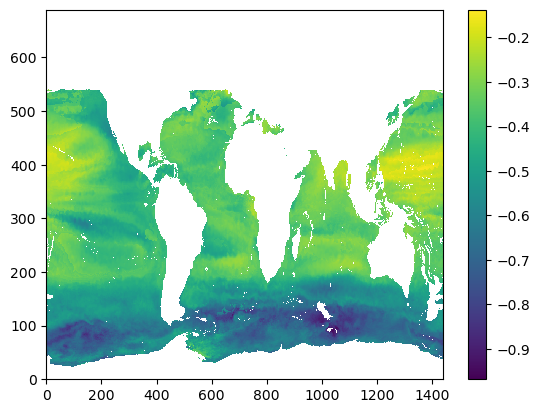

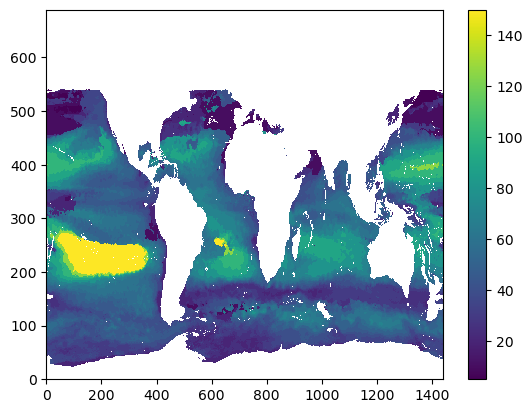

In [71]:
%%time

plt.figure()
plt.pcolormesh(b_da.isel(time=0))
plt.colorbar()

plt.figure()
plt.pcolormesh(zref_da.isel(time=0))
plt.colorbar()

b_da.to_netcdf("/g/data/es60/observations/copernicus_chlorophyll_obsprod/poc_flux_martinb.nc")
zref_da.to_netcdf("/g/data/es60/observations/copernicus_chlorophyll_obsprod/poc_flux_zref.nc")


1086.0643
-0.7193592


(1000.0, 0.0)

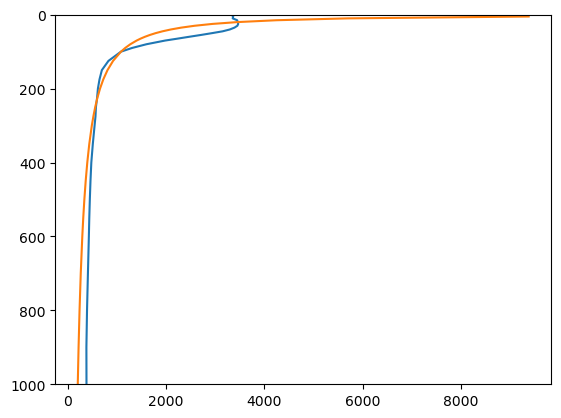

In [61]:
def fpoc_martinb(b,z, zref,fpoc_ref):
    return fpoc_ref * (z/zref)**(b)

zz = 100.0
xx = 600
yy = 100
print(fpoc.isel(time=0, longitude=xx, latitude=yy).sel(depth=zz, method='nearest').values)
print(b_da.isel(time=0, longitude=xx, latitude=yy).values)
bprof = fpoc_martinb(b_da.isel(time=0, longitude=xx, latitude=yy).values, deps, zz, fpoc.isel(time=0, longitude=xx, latitude=yy).sel(depth=zz, method='nearest').values)

plt.figure()
plt.plot(fpoc.isel(time=0, longitude=xx, latitude=yy), deps)
plt.plot(bprof, deps)
plt.ylim(1000,0)

### Get and regrid the bathymetry data to the POC flux data

In [85]:
bathy = xr.open_dataset("/g/data/es60/observations/etopo5.nc")

print("Regridding model")
ds_in = xr.Dataset(
    {'bathy': ( ('latitude', 'longitude'), bathy.ROSE.values),
     },
    coords={"longitude": (['longitude'], bathy.coords['ETOPO05_X'].values),
            "latitude": (['latitude'], bathy.coords['ETOPO05_Y'].values),
            }
    )

ds_out = xr.Dataset({
    'latitude': (['latitude'], fpoc.latitude.data),
    'longitude': (['longitude'], fpoc.longitude.data)
})

regridder = xe.Regridder(ds_in, ds_out, 'nearest_s2d')
bathy_reg = regridder(ds_in['bathy'])
bathy_reg


Regridding model


<xarray.DataArray (latitude: 689, longitude: 1440)>
array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [-3871., -3868., -3866., ..., -3898., -3887., -3877.],
       [-4231., -4229., -4228., ..., -4235., -4234., -4232.],
       [-4278., -4277., -4277., ..., -4279., -4278., -4278.]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    regrid_method:  nearest_s2d

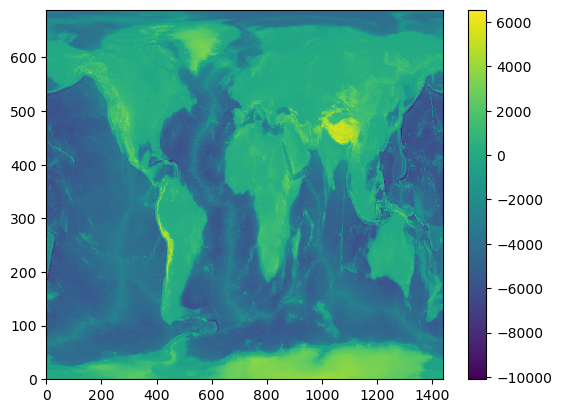

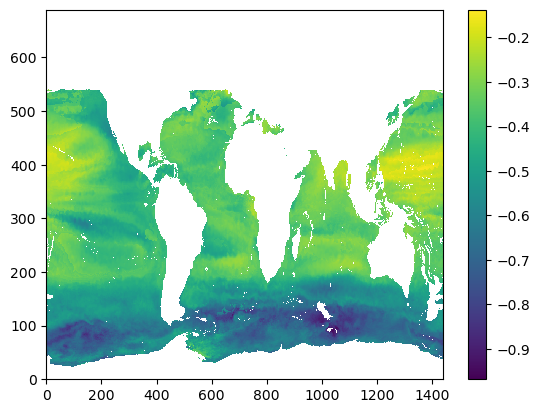

In [86]:
plt.figure()
plt.pcolormesh(bathy_reg)
plt.colorbar()

plt.figure()
plt.pcolormesh(b_da.isel(time=0))
plt.colorbar()


### solve for the flux at the bottom

CPU times: user 7.41 s, sys: 4.37 s, total: 11.8 s
Wall time: 11.8 s


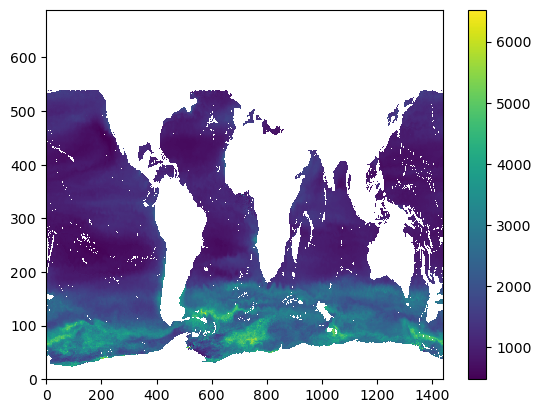

In [87]:
%%time

F_ref = fpoc.interp(depth=zref_da)
F_ref


plt.figure()
plt.pcolormesh(F_ref.isel(time=0))
plt.colorbar()


In [88]:
%%time
# Suppose b_da has dims [time, lat, lon].
# "broadcast_like" matches all dims from b_da, adding time as needed:
bathy_3d = bathy_reg.broadcast_like(b_da)
bathy_3d


CPU times: user 3.03 ms, sys: 265 μs, total: 3.3 ms
Wall time: 3.07 ms


<xarray.DataArray (time: 12, latitude: 689, longitude: 1440)>
array([[[    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        ...,
        [-3871., -3868., -3866., ..., -3898., -3887., -3877.],
        [-4231., -4229., -4228., ..., -4235., -4234., -4232.],
        [-4278., -4277., -4277., ..., -4279., -4278., -4278.]],

       [[    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        ...,
        [-3871., -3868., -3866., ..., -3898., -3887., -3877.],
        [-4231., -4229., -4228., ..., -4235., -4234., -4232.],
        [-4278., -4277., -4277., ..., -4279., -4278., -4278.]],

       [[    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        ...,
...
        [-3871., -3868., -3866., ..., -3898., -3887., -3877.],
        [-4231., -4229., -4228., ..., -4235., -4234., -4232.],
        [-4278., -4277., -4277., ..., -4279., -4278., -4278.]],

       [[    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        ...,
        [-3871., -3868., -3866., ..., -3898., -3887., -3877.],
        [-4231., -4229., -4228., ..., -4235., -4234., -4232.],
        [-4278., -4277., -4277., ..., -4279., -4278., -4278.]],

       [[    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        [    0.,     0.,     0., ...,     0.,     0.,     0.],
        ...,
        [-3871., -3868., -3866., ..., -3898., -3887., -3877.],
        [-4231., -4229., -4228., ..., -4235., -4234., -4232.],
        [-4278., -4277., -4277., ..., -4279., -4278., -4278.]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 1998-01-15 1998-02-15 ... 1998-12-15
Attributes:
    regrid_method:  nearest_s2d

CPU times: user 724 ms, sys: 3.71 ms, total: 727 ms
Wall time: 724 ms


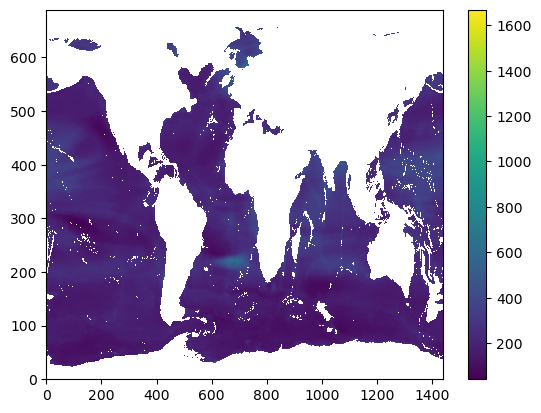

In [95]:
%%time

fpoc_bottom = F_ref * (-bathy_3d / zref_da) ** (b_da)
fpoc_bottom.name = 'fpoc'
fpoc_bottom.attrs['units'] = 'mg C m^-2 d^-1'  # or whatever flux units

plt.figure()
plt.pcolormesh(fpoc_bottom.mean(dim="time"))
plt.colorbar()


In [96]:
fpoc_bottom.to_netcdf("/g/data/es60/observations/copernicus_chlorophyll_obsprod/poc_flux_bottom.nc")
